Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query
Response: <Response [200]>

Set of all unique security types found in the data:
{'CMB', 'Bond', 'TIPS Note', 'Bill', 'TIPS Bond', 'Note', 'FRN Note'}
(6022, 6)
(6019, 6)

Preview of yearly issuance data:
(20, 4)
category          Bill          Bond          Note         Other
year                                                            
2006      3.391226e+12  4.639796e+10  7.421478e+11  2.420021e+11
2007      3.486298e+12  5.448508e+10  6.977195e+11  2.560029e+11
2008      4.195442e+12  6.366661e+10  9.657788e+11  1.432009e+12
2009      5.275833e+12  1.513329e+11  2.045879e+12  1.142012e+12
2010      4.852568e+12  1.898829e+11  2.129860e+12  1.247029e+12


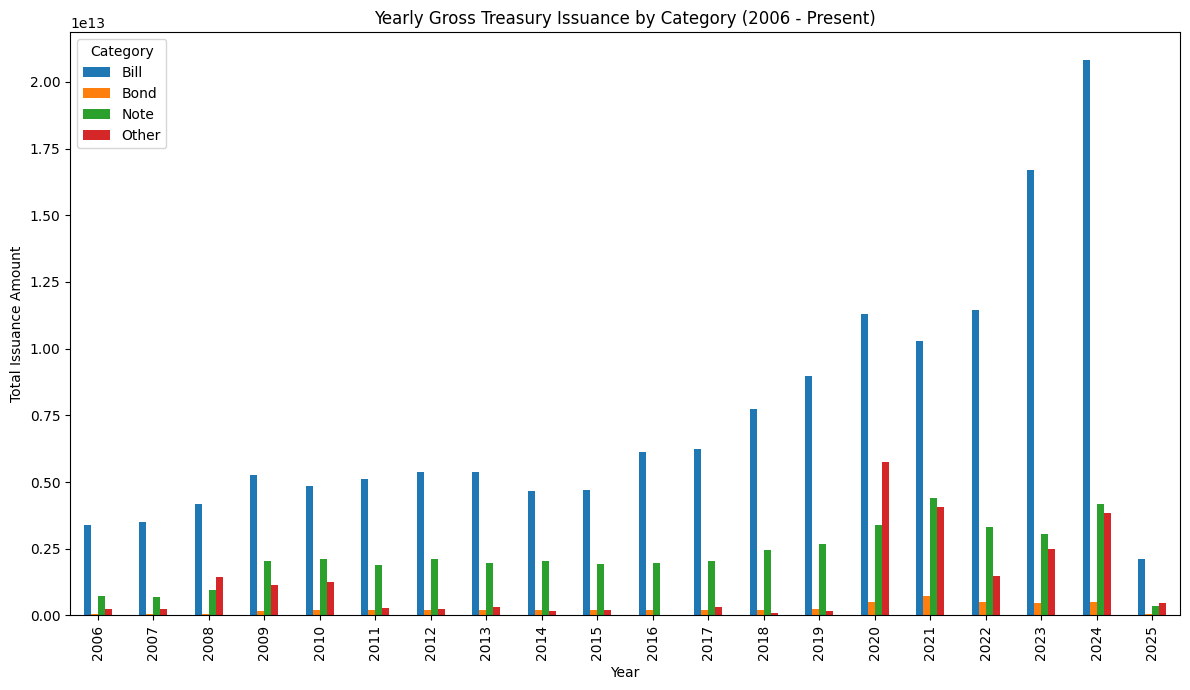

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Base URL for the Fiscal Data Treasury API.
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
# Using the auctions_query endpoint from the accounting/od dataset (v1).
endpoint = "/v1/accounting/od/auctions_query"

# Set query parameters:
params = {
    "fields": "record_date,security_type,security_term,total_accepted,maturity_date",
    "sort": "-record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

# Set up headers.
headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

# Construct the URL and make the API request.
url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
data = json_response["data"]

# Load the JSON data into a DataFrame.
df = pd.DataFrame(data)

# Convert date fields to datetime.
df["record_date"] = pd.to_datetime(df["record_date"])
df["maturity_date"] = pd.to_datetime(df["maturity_date"], errors="coerce")

# Convert the accepted amount to numeric.
df["total_accepted"] = pd.to_numeric(df["total_accepted"], errors="coerce")

# ** Collect all unique security types in the dataset **
unique_security_types = set(df["security_type"].dropna())

print("\nSet of all unique security types found in the data:")
print(unique_security_types)

# Function to classify each security into one of three groups.
def categorize_security(security_type):
    if "Bill" in security_type:
        return "Bill"
    elif "Note" in security_type or "Coupon" in security_type:
        return "Note"
    elif "Bond" in security_type:
        return "Bond"
    else:
        return "Other"

# Create a new column for the security category.
df["category"] = df["security_type"].apply(categorize_security)

# Optionally, drop rows without a valid total_accepted amount.
print(df.shape)  # Output: (number_of_rows, number_of_columns)

df = df.dropna(subset=["total_accepted"])
print(df.shape)  # Output: (number_of_rows, number_of_columns)


# --- Aggregation by Year ---
df["year"] = df["record_date"].dt.year
yearly_issuance = df.groupby(["year", "category"])["total_accepted"].sum().reset_index()

# Pivot the table so that each year is a row and columns represent each category.
pivot_df = yearly_issuance.pivot(index="year", columns="category", values="total_accepted")
pivot_df = pivot_df.fillna(0)  # Replace missing values with 0

print("\nPreview of yearly issuance data:")
print(pivot_df.shape)  # Output: (number_of_rows, number_of_columns)
print(pivot_df.head())

# --- Plotting ---
pivot_df.plot(kind="bar", figsize=(12, 7))
plt.xlabel("Year")
plt.ylabel("Total Issuance Amount")
plt.title("Yearly Gross Treasury Issuance by Category (2006 - Present)")
plt.legend(title="Category")
plt.tight_layout()
plt.show()

Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query
Response: <Response [200]>

Unique security types found:
{'Note', 'TIPS Bond', 'TIPS Note', 'CMB', 'Bill', 'Bond', 'FRN Note'}


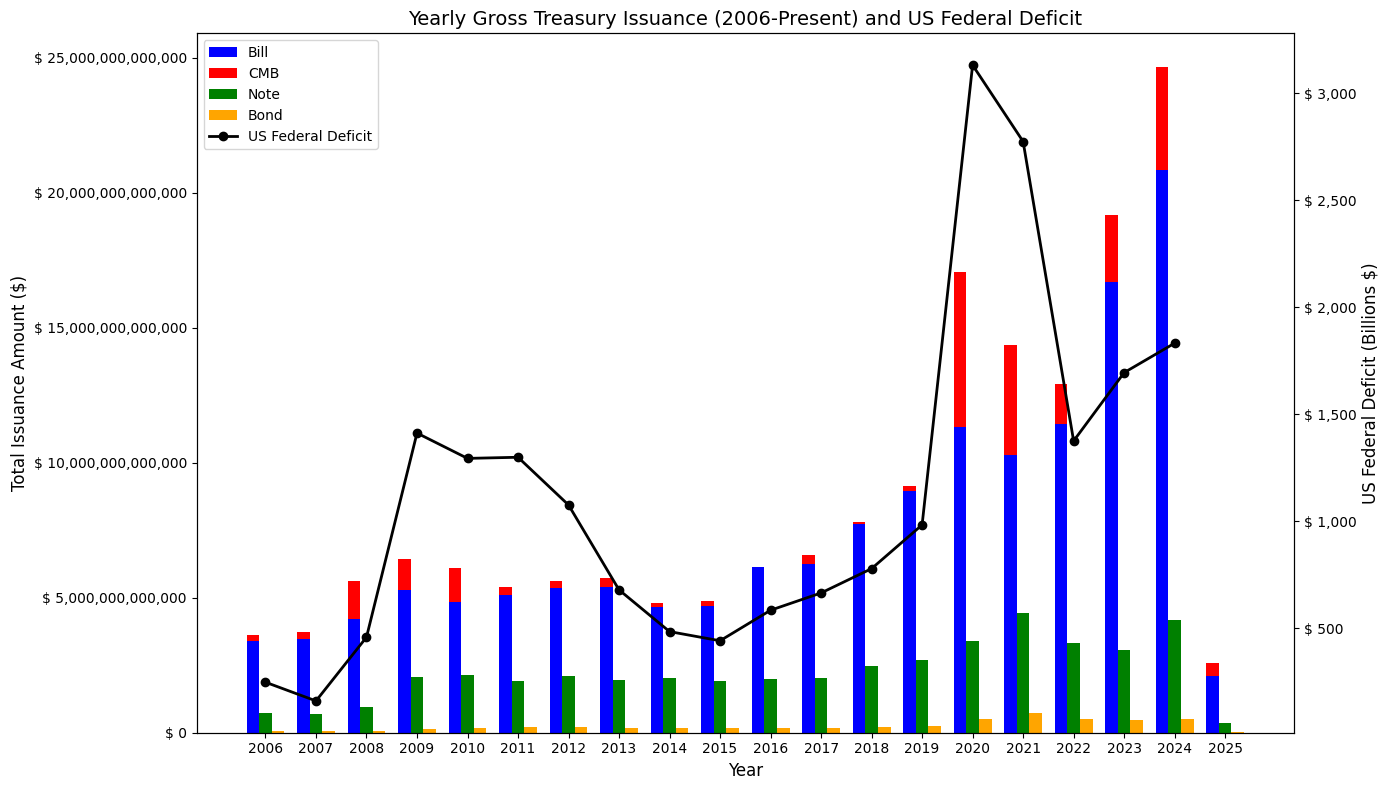

In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter

# -----------------------------
# Part 1: Retrieve Treasury Auction Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/accounting/od/auctions_query"

params = {
    "fields": "record_date,security_type,security_term,total_accepted,maturity_date",
    "sort": "-record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

df["record_date"] = pd.to_datetime(df["record_date"])
df["maturity_date"] = pd.to_datetime(df["maturity_date"], errors='coerce')
df["total_accepted"] = pd.to_numeric(df["total_accepted"], errors="coerce")

unique_security_types = set(df["security_type"].dropna())
print("\nUnique security types found:")
print(unique_security_types)

# -----------------------------
# Part 2: Categorize Securities
# -----------------------------
def categorize_security(security_type):
    if "CMB" in security_type or "Cash Management" in security_type:
        return "CMB"
    elif "Bill" in security_type:
        return "Bill"
    elif "Note" in security_type or "Coupon" in security_type:
        return "Coupon"
    elif "Bond" in security_type:
        return "Bond"
    else:
        return "Other"

df["category"] = df["security_type"].apply(categorize_security)
df = df.dropna(subset=["total_accepted"])

# -----------------------------
# Part 3: Aggregate Issuance by Year
# -----------------------------
df["year"] = df["record_date"].dt.year
yearly_issuance = df.groupby(["year", "category"])["total_accepted"].sum().reset_index()
pivot_df = yearly_issuance.pivot(index="year", columns="category", values="total_accepted")
pivot_df = pivot_df.fillna(0)

years = sorted(pivot_df.index)
bill_vals = pivot_df.get("Bill", pd.Series(0, index=years))
cmb_vals = pivot_df.get("CMB", pd.Series(0, index=years))
coupon_vals = pivot_df.get("Coupon", pd.Series(0, index=years))
bond_vals = pivot_df.get("Bond", pd.Series(0, index=years))

# -----------------------------
# Part 4: Retrieve US Federal Deficit Data from FRED
# -----------------------------
# Retrieve the deficit series (FYFSD) via FRED.
fred = Fred(api_key="b1b93f854d911b3cdc94df6dd9ec0365")
deficit_series = fred.get_series("FYFSD", observation_start="2006-01-01")
deficit_annual = deficit_series.resample("YE").mean()

# Invert the deficit (multiply by -1) so that a deficit (negative) becomes positive.
# Then, divide by 1,000 to convert the raw values (likely in millions) to billions.
deficit_annual = (-deficit_annual) / 1000

# Convert the index to the year.
deficit_annual.index = deficit_annual.index.year
deficit_annual = deficit_annual.reindex(years, fill_value=np.nan)

# -----------------------------
# Part 5: Plot Grouped Bars and Federal Deficit Line
# -----------------------------
x = np.arange(len(years))
width = 0.25

fig, ax1 = plt.subplots(figsize=(14, 8))

# Stacked bar: Bills (blue) and CMBs (red) grouped together.
ax1.bar(x - width, bill_vals, width, color='blue', label='Bill')
ax1.bar(x - width, cmb_vals, width, bottom=bill_vals, color='red', label='CMB')
ax1.bar(x, coupon_vals, width, color='green', label='Note')
ax1.bar(x + width, bond_vals, width, color='orange', label='Bond')

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Total Issuance Amount ($)", fontsize=12)
ax1.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))
ax1.set_title("Yearly Gross Treasury Issuance (2006-Present) and US Federal Deficit", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Secondary y-axis for US federal deficit.
ax2 = ax1.twinx()
ax2.plot(x, deficit_annual.values, color='black', marker='o', linewidth=2, label="US Federal Deficit")
ax2.set_ylabel("US Federal Deficit (Billions $)", fontsize=12)
ax2.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))

bars, labels = ax1.get_legend_handles_labels()
line, line_label = ax2.get_legend_handles_labels()
ax1.legend(bars + line, labels + line_label, loc='upper left')

plt.tight_layout()
plt.show()


Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query
Response: <Response [200]>

Unique security types found:
{'Bond', 'TIPS Note', 'TIPS Bond', 'CMB', 'Note', 'FRN Note', 'Bill'}

Outstanding Debt by Year (per category):
category          Bill          Bond           CMB        Coupon
2006      9.441550e+11  4.639796e+10  0.000000e+00  7.421478e+11
2007      1.003845e+12  1.008830e+11  0.000000e+00  1.413201e+12
2008      1.305435e+12  1.645497e+11  5.610030e+11  2.069915e+12
2009      1.633444e+12  3.158826e+11  1.600032e+11  3.740941e+12
2010      1.572445e+12  5.057655e+11  2.000037e+11  5.427172e+12


/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_22163/2744537913.py:112: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  deficit_annual = deficit_series.resample("A").mean()


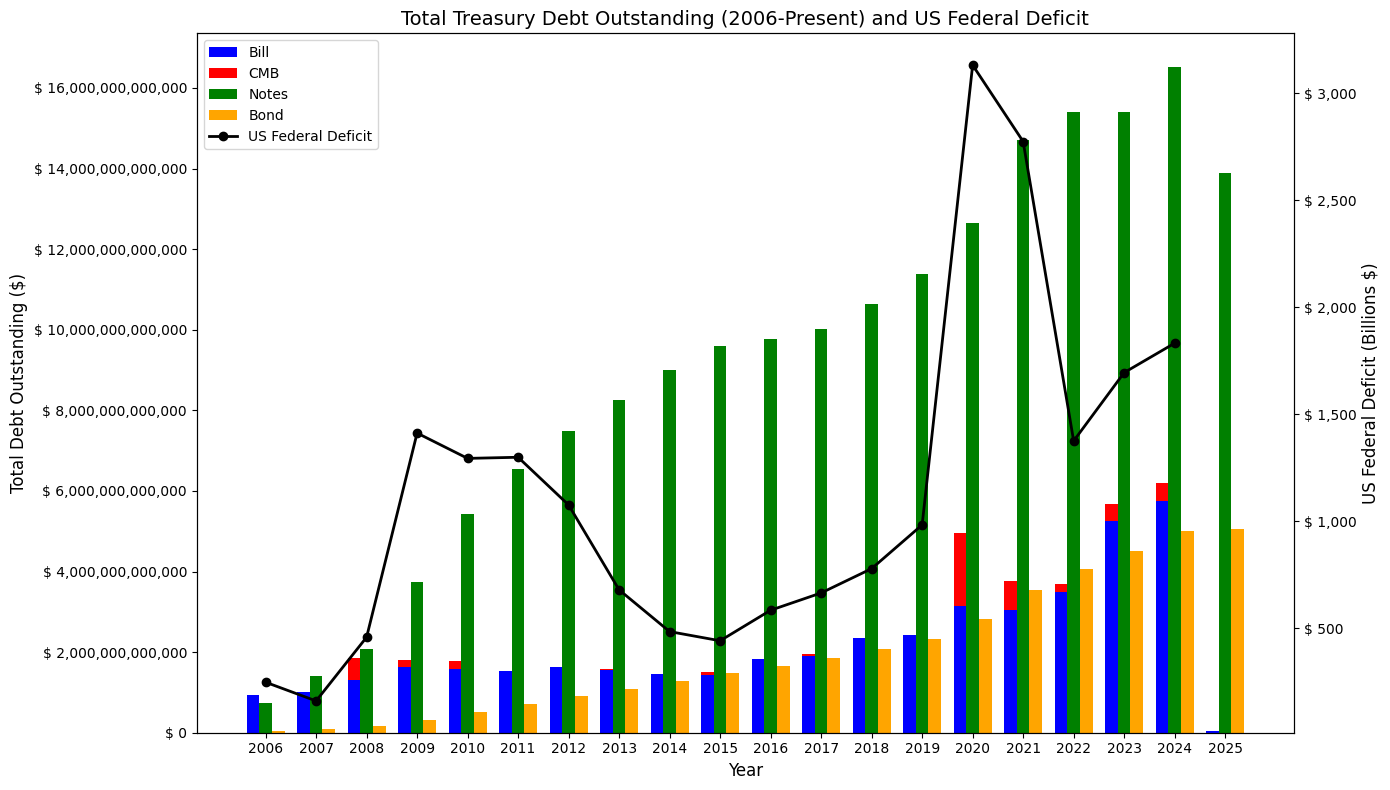

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime, timedelta
from matplotlib.ticker import StrMethodFormatter

# -----------------------------
# Part 1: Retrieve Treasury Auction Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/accounting/od/auctions_query"

params = {
    "fields": "record_date,security_type,security_term,total_accepted,maturity_date",
    "sort": "-record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

df["record_date"] = pd.to_datetime(df["record_date"])
df["maturity_date"] = pd.to_datetime(df["maturity_date"], errors='coerce')
df["total_accepted"] = pd.to_numeric(df["total_accepted"], errors="coerce")

unique_security_types = set(df["security_type"].dropna())
print("\nUnique security types found:")
print(unique_security_types)

# -----------------------------
# Part 2: Categorize Securities
# -----------------------------
def categorize_security(security_type):
    if "CMB" in security_type or "Cash Management" in security_type:
        return "CMB"
    elif "Bill" in security_type:
        return "Bill"
    elif "Note" in security_type or "Coupon" in security_type:
        return "Coupon"
    elif "Bond" in security_type:
        return "Bond"
    else:
        return "Other"

df["category"] = df["security_type"].apply(categorize_security)
df = df.dropna(subset=["total_accepted"])

# -----------------------------
# Part 3: Compute Outstanding Debt Outstanding per Year
# -----------------------------
# We want to calculate, for each year, the total amount of securities still outstanding as of December 31.
# For each year Y, we include a record if:
#   record_date <= December 31 of Y  AND  maturity_date > December 31 of Y.
start_year = 2006
current_year = datetime.today().year
years = list(range(start_year, current_year + 1))

# Create a DataFrame to hold outstanding amounts per category per year.
outstanding_dict = {}

for yr in years:
    # Define the "evaluation date" as December 31 of the given year.
    end_of_year = pd.Timestamp(year=yr, month=12, day=31)
    # Filter records that have been issued and that have not yet matured as of end_of_year.
    active = df[(df["record_date"] <= end_of_year) & (df["maturity_date"] > end_of_year)]
    # Group by category and sum the total accepted amounts.
    grp = active.groupby("category")["total_accepted"].sum()
    outstanding_dict[yr] = grp

# Convert outstanding_dict to a DataFrame.
outstanding_df = pd.DataFrame(outstanding_dict).T.fillna(0)
print("\nOutstanding Debt by Year (per category):")
print(outstanding_df.head())

# For plotting the grouped bars, we want to extract values for our chosen categories.
# We'll assume we want:
#  - "Bill" (standard Treasury Bills) and "CMB" (Cash Management Bills) combined in one grouped bar as a stacked bar.
#  - "Coupon" (e.g., Treasury Notes) and "Bond" separately.
bill_vals = outstanding_df.get("Bill", pd.Series(0, index=years))
cmb_vals = outstanding_df.get("CMB", pd.Series(0, index=years))
coupon_vals = outstanding_df.get("Coupon", pd.Series(0, index=years))
bond_vals = outstanding_df.get("Bond", pd.Series(0, index=years))

# -----------------------------
# Part 4: Retrieve US Federal Deficit Data from FRED
# -----------------------------
fred = Fred(api_key="b1b93f854d911b3cdc94df6dd9ec0365")
deficit_series = fred.get_series("FYFSD", observation_start="2006-01-01")
# Resample to annual values using year-end; FYFSD is typically reported in millions.
deficit_annual = deficit_series.resample("A").mean()

# Invert the deficit (multiply by -1) to show it as a positive number.
# Then, divide by 1000 to convert the values to billions.
deficit_annual = (-deficit_annual) / 1000

# Convert the index to year.
deficit_annual.index = deficit_annual.index.year
# Reindex to our set of years.
deficit_annual = deficit_annual.reindex(years, fill_value=np.nan)

# -----------------------------
# Part 5: Plot Grouped Bars and Federal Deficit Line
# -----------------------------
x = np.arange(len(years))
width = 0.25  # Bar width

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot a stacked bar for Bills (blue) and CMBs (red).
ax1.bar(x - width, bill_vals, width, color='blue', label='Bill')
ax1.bar(x - width, cmb_vals, width, bottom=bill_vals, color='red', label='CMB')
# Plot Coupon (green) and Bond (orange) as separate bars.
ax1.bar(x, coupon_vals, width, color='green', label='Notes')
ax1.bar(x + width, bond_vals, width, color='orange', label='Bond')

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Total Debt Outstanding ($)", fontsize=12)
ax1.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))
ax1.set_title("Total Treasury Debt Outstanding (2006-Present) and US Federal Deficit", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Secondary y-axis for US Federal Deficit.
ax2 = ax1.twinx()
ax2.plot(x, deficit_annual.values, color='black', marker='o', linewidth=2, label="US Federal Deficit")
ax2.set_ylabel("US Federal Deficit (Billions $)", fontsize=12)
ax2.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))

bars, labels = ax1.get_legend_handles_labels()
line, line_label = ax2.get_legend_handles_labels()
ax1.legend(bars + line, labels + line_label, loc='upper left')

plt.tight_layout()
plt.show()

Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/debt/mspd/mspd_table_1
Response: <Response [200]>
Unique security_class_desc values in the dataset:
{'Government Account Series', 'Domestic Series', 'Floating Rate Notes', 'Notes', 'R.E.A. Series', '_', 'Other', 'Federal Financing Bank', 'United States Savings Securities', 'Hope Bonds', 'Foreign Series', 'State and Local Government Series', 'Bonds', 'Treasury Inflation-Protected Securities', 'Bills'}
Data after categorization (first 5 rows):
  record_date                      security_class_desc  total_mil_amt category
0  2006-01-31                                    Bills   9.562498e+05     Bill
1  2006-01-31                                    Notes   2.361102e+06     Note
2  2006-01-31                                    Bonds   5.166188e+05     Bond
3  2006-01-31  Treasury Inflation-Protected Securities   3.468606e+05     Tips
4  2006-01-31                   Federal Financing Bank   1.400000e+04    Other


/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_83390/1143040156.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])
/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_83390/1143040156.py:107: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  deficit_annual = deficit_series.resample("A").mean()


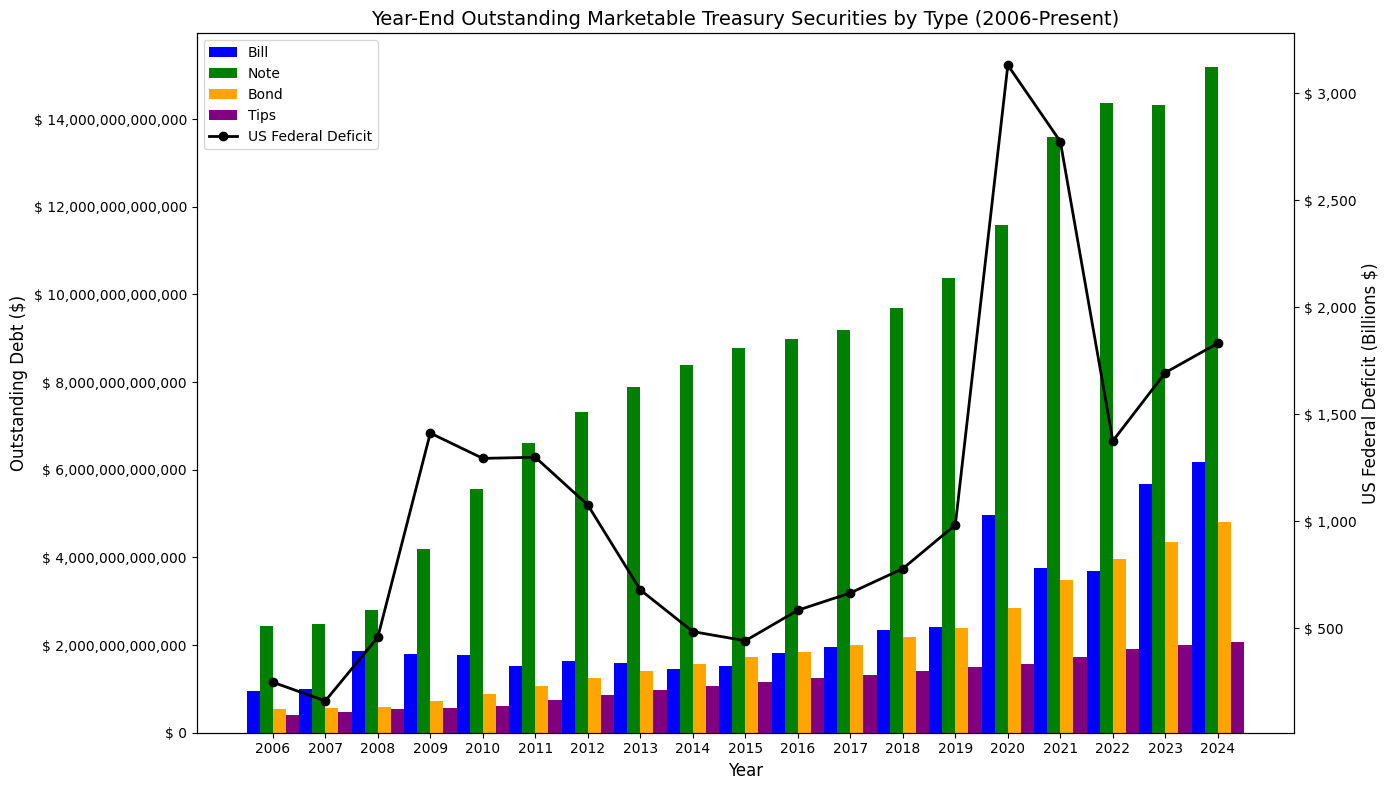

In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter

# -----------------------------
# Part 1: Retrieve the Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/debt/mspd/mspd_table_1"

# Using fields: record_date, security_class_desc, and total_mil_amt.
params = {
    "fields": "record_date,security_class_desc,total_mil_amt",
    "sort": "record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

# Convert record_date to datetime and total_mil_amt to numeric.
df["record_date"] = pd.to_datetime(df["record_date"])
df["total_mil_amt"] = pd.to_numeric(df["total_mil_amt"], errors="coerce")

# Print unique security_class_desc values.
unique_sec_types = set(df["security_class_desc"].unique())
print("Unique security_class_desc values in the dataset:")
print(unique_sec_types)

# -----------------------------
# Part 2: Categorize by Security Type
# -----------------------------
def categorize_security_desc(desc):
    desc = desc.lower()
    if "bill" in desc:
        return "Bill"
    elif "note" in desc:
        return "Note"
    elif "bond" in desc:
        return "Bond"
    elif "inflation" in desc:
        return "Tips"
    else:
        return "Other"

df["category"] = df["security_class_desc"].apply(categorize_security_desc)
print("Data after categorization (first 5 rows):")
print(df.head())

# -----------------------------
# Part 3: Get Year-End Outstanding Values
# -----------------------------
# Reset the index so that record_date is a column.
df_reset = df.reset_index(drop=True)
# Group by record_date and category, summing total_mil_amt for each day.
daily_pivot = df_reset.groupby(["record_date", "category"])["total_mil_amt"].sum().unstack(fill_value=0)
# daily_pivot now has one row per record_date with columns for each category.

# For each year, select the row with the maximum record_date.
daily_pivot["year"] = daily_pivot.index.year
annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])
# Set the index to be the year.
annual_data.index = annual_data.index.get_level_values(0)
# Convert outstanding amounts from millions to dollars.
annual_data = annual_data * 1e6

print("Annual Outstanding Debt by Type (Year-End):")
print(annual_data.head())

# Extract the values for each category.
years = sorted(annual_data.index)
bills = annual_data.get("Bill", pd.Series(0, index=years))
notes = annual_data.get("Note", pd.Series(0, index=years))
bonds = annual_data.get("Bond", pd.Series(0, index=years))
others = annual_data.get("Tips", pd.Series(0, index=years))

# -----------------------------
# Part 4: Retrieve US Federal Deficit Data from FRED (for context)
# -----------------------------
fred = Fred(api_key="b1b93f854d911b3cdc94df6dd9ec0365")
deficit_series = fred.get_series("FYFSD", observation_start="2006-01-01")
# Resample to annual using year-end values (using the mean for demonstration).
deficit_annual = deficit_series.resample("A").mean()
# Invert the deficit (multiply by -1) so that deficits appear as positive numbers,
# and divide by 1000 to convert to billions (if raw data are in millions).
deficit_annual = (-deficit_annual) / 1000
deficit_annual.index = deficit_annual.index.year
deficit_annual = deficit_annual.reindex(years, fill_value=np.nan)

# -----------------------------
# Part 5: Plot the Data
# -----------------------------
# We want 4 bars per year. We'll position them with an offset:
#   Bills at x - 1.5*width, Notes at x - 0.5*width, Bonds at x + 0.5*width, Other at x + 1.5*width.
x = np.arange(len(years))
width = 0.25  # Bar width

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.bar(x - 1.5 * width, bills, width, color='blue', label='Bill')
ax1.bar(x - 0.5 * width, notes, width, color='green', label='Note')
ax1.bar(x + 0.5 * width, bonds, width, color='orange', label='Bond')
ax1.bar(x + 1.5 * width, others, width, color='purple', label='Tips')

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Outstanding Debt ($)", fontsize=12)
ax1.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))
ax1.set_title("Year-End Outstanding Marketable Treasury Securities by Type (2006-Present)", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Secondary y-axis for the US Federal Deficit.
ax2 = ax1.twinx()
ax2.plot(x, deficit_annual.values, color='black', marker='o', linewidth=2, label="US Federal Deficit")
ax2.set_ylabel("US Federal Deficit (Billions $)", fontsize=12)
ax2.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))

# Combine legends from both axes.
bars, labels = ax1.get_legend_handles_labels()
line, line_label = ax2.get_legend_handles_labels()
ax1.legend(bars + line, labels + line_label, loc='upper left')

plt.tight_layout()
plt.show()

/Users/aidansinclair/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/debt/mspd/mspd_table_1
Response: <Response [200]>
Raw Data (first 5 rows):
  record_date                      security_class_desc  total_mil_amt
0  2006-01-31                                    Bills   9.562498e+05
1  2006-01-31                                    Notes   2.361102e+06
2  2006-01-31                                    Bonds   5.166188e+05
3  2006-01-31  Treasury Inflation-Protected Securities   3.468606e+05
4  2006-01-31                   Federal Financing Bank   1.400000e+04
Data after categorization (first 5 rows):
  record_date                      security_class_desc  total_mil_amt category
0  2006-01-31                                    Bills   9.562498e+05     Bill
1  2006-01-31                                    Notes   2.361102e+06     Note
2  2006-01-31                                    Bonds   5.166188e+05     Bond
3  2006-01-31  Treasury Inflation-Protected Securities   3.468606e+

/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_84108/2805110211.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])


Year-Over-Year Growth (%):
category       Bill       Note       Bond       Tips
year                                                
2007       6.317481   1.909474   5.249057  14.711651
2008      85.946152  12.204995   6.551733  12.390444
2009      -3.920670  49.742085  20.716708   7.153940
2010      -1.168266  33.260097  24.318387   8.458723
2011     -14.217583  18.545475  19.199074  19.907286


/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_84108/2805110211.py:104: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  deficit_annual = deficit_series.resample("A").mean()


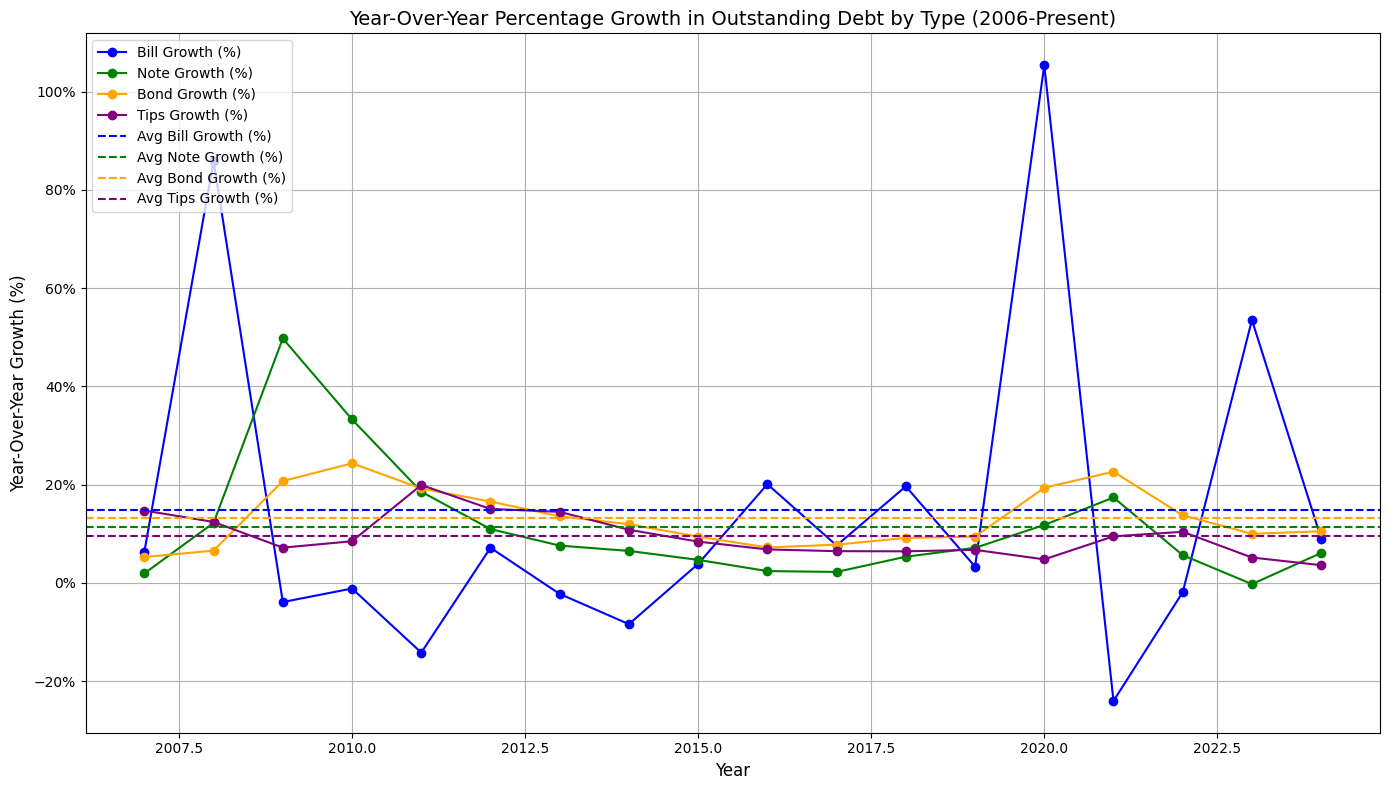

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime
from matplotlib.ticker import PercentFormatter

# -----------------------------
# Part 1: Retrieve the Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/debt/mspd/mspd_table_1"

params = {
    "fields": "record_date,security_class_desc,total_mil_amt",
    "sort": "record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

# Convert record_date to datetime and total_mil_amt to numeric.
df["record_date"] = pd.to_datetime(df["record_date"])
df["total_mil_amt"] = pd.to_numeric(df["total_mil_amt"], errors="coerce")

print("Raw Data (first 5 rows):")
print(df.head())

# -----------------------------
# Part 2: Categorize by Security Type
# -----------------------------
def categorize_security_desc(desc):
    desc = desc.lower()
    if "bill" in desc:
        return "Bill"
    elif "note" in desc:
        return "Note"
    elif "bond" in desc:
        return "Bond"
    elif "inflation" in desc:  # assuming this identifies TIPS
        return "Tips"
    else:
        return "Other"

df["category"] = df["security_class_desc"].apply(categorize_security_desc)
print("Data after categorization (first 5 rows):")
print(df.head())

# -----------------------------
# Part 3: Get Year-End Outstanding Values
# -----------------------------
# Reset the index so that record_date is a column.
df_reset = df.reset_index(drop=True)
# Group by record_date and category, summing total_mil_amt for that day.
daily_pivot = df_reset.groupby(["record_date", "category"])["total_mil_amt"].sum().unstack(fill_value=0)
# daily_pivot now has one row per record_date with columns for each category.

# For each year, select the row with the maximum record_date (year-end snapshot).
daily_pivot["year"] = daily_pivot.index.year
annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])
# Set the index to be the year.
annual_data.index = annual_data.index.get_level_values(0)
# Convert outstanding amounts from millions to dollars.
annual_data_debt = annual_data.drop(columns="year") * 1e6

print("Annual Outstanding Debt by Type (Year-End):")
print(annual_data.head())

# Extract the values for each category.
years = sorted(annual_data.index)
bills = annual_data.get("Bill", pd.Series(0, index=years))
notes = annual_data.get("Note", pd.Series(0, index=years))
bonds = annual_data.get("Bond", pd.Series(0, index=years))
tips = annual_data.get("Tips", pd.Series(0, index=years))

# -----------------------------
# Part 4: Retrieve US Federal Deficit Data from FRED (for context)
# -----------------------------
fred = Fred(api_key="b1b93f854d911b3cdc94df6dd9ec0365")
deficit_series = fred.get_series("FYFSD", observation_start="2006-01-01")
# Resample to annual using year-end values (using the mean for demonstration).
deficit_annual = deficit_series.resample("A").mean()
# Invert the deficit (multiply by -1) so that deficits appear as positive numbers,
# and divide by 1000 to convert (if raw data are in millions) to billions.
deficit_annual = (-deficit_annual) / 1000
deficit_annual.index = deficit_annual.index.year
deficit_annual = deficit_annual.reindex(years, fill_value=np.nan)

# -----------------------------
# Part 5: Compute Year-Over-Year Percentage Growth
# -----------------------------
growth_data = annual_data.pct_change() * 100  # compute percentage change
# Select only the four desired categories.
growth_data = growth_data[["Bill", "Note", "Bond", "Tips"]]
growth_data = growth_data.dropna()  # drop the first year which will be NaN

print("Year-Over-Year Growth (%):")
print(growth_data.head())

# -----------------------------
# Part 6: Plot the YOY Growth Data with Average Growth Lines
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 8))

# Plot lines for each category.
ax.plot(growth_data.index, growth_data["Bill"], marker='o', color='blue', label='Bill Growth (%)')
ax.plot(growth_data.index, growth_data["Note"], marker='o', color='green', label='Note Growth (%)')
ax.plot(growth_data.index, growth_data["Bond"], marker='o', color='orange', label='Bond Growth (%)')
ax.plot(growth_data.index, growth_data["Tips"], marker='o', color='purple', label='Tips Growth (%)')

# Compute average growth for each category.
avg_bill = growth_data["Bill"].mean()
avg_note = growth_data["Note"].mean()
avg_bond = growth_data["Bond"].mean()
avg_tips = growth_data["Tips"].mean()

# Plot horizontal dashed lines for the average growth for each category.
ax.axhline(y=avg_bill, color='blue', linestyle='--', label='Avg Bill Growth (%)')
ax.axhline(y=avg_note, color='green', linestyle='--', label='Avg Note Growth (%)')
ax.axhline(y=avg_bond, color='orange', linestyle='--', label='Avg Bond Growth (%)')
ax.axhline(y=avg_tips, color='purple', linestyle='--', label='Avg Tips Growth (%)')

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Year-Over-Year Growth (%)", fontsize=12)
ax.set_title("Year-Over-Year Percentage Growth in Outstanding Debt by Type (2006-Present)", fontsize=14)
ax.grid(True)
ax.legend(loc='upper left')

# Format y-axis as percentages.
ax.yaxis.set_major_formatter(PercentFormatter())

plt.tight_layout()
plt.show()

Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/debt/mspd/mspd_table_1
Response: <Response [200]>
Unique security_class_desc values in the dataset:
{'Government Account Series', 'Domestic Series', 'Floating Rate Notes', 'Notes', 'R.E.A. Series', '_', 'Other', 'Federal Financing Bank', 'United States Savings Securities', 'Hope Bonds', 'Foreign Series', 'State and Local Government Series', 'Bonds', 'Treasury Inflation-Protected Securities', 'Bills'}
Data after categorization (first 5 rows):
  record_date                      security_class_desc  total_mil_amt category
0  2006-01-31                                    Bills   9.562498e+05     Bill
1  2006-01-31                                    Notes   2.361102e+06     Note
2  2006-01-31                                    Bonds   5.166188e+05     Bond
3  2006-01-31  Treasury Inflation-Protected Securities   3.468606e+05     Tips
4  2006-01-31                   Federal Financing Bank   1.400000e+04    Other


/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_83390/875576622.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])


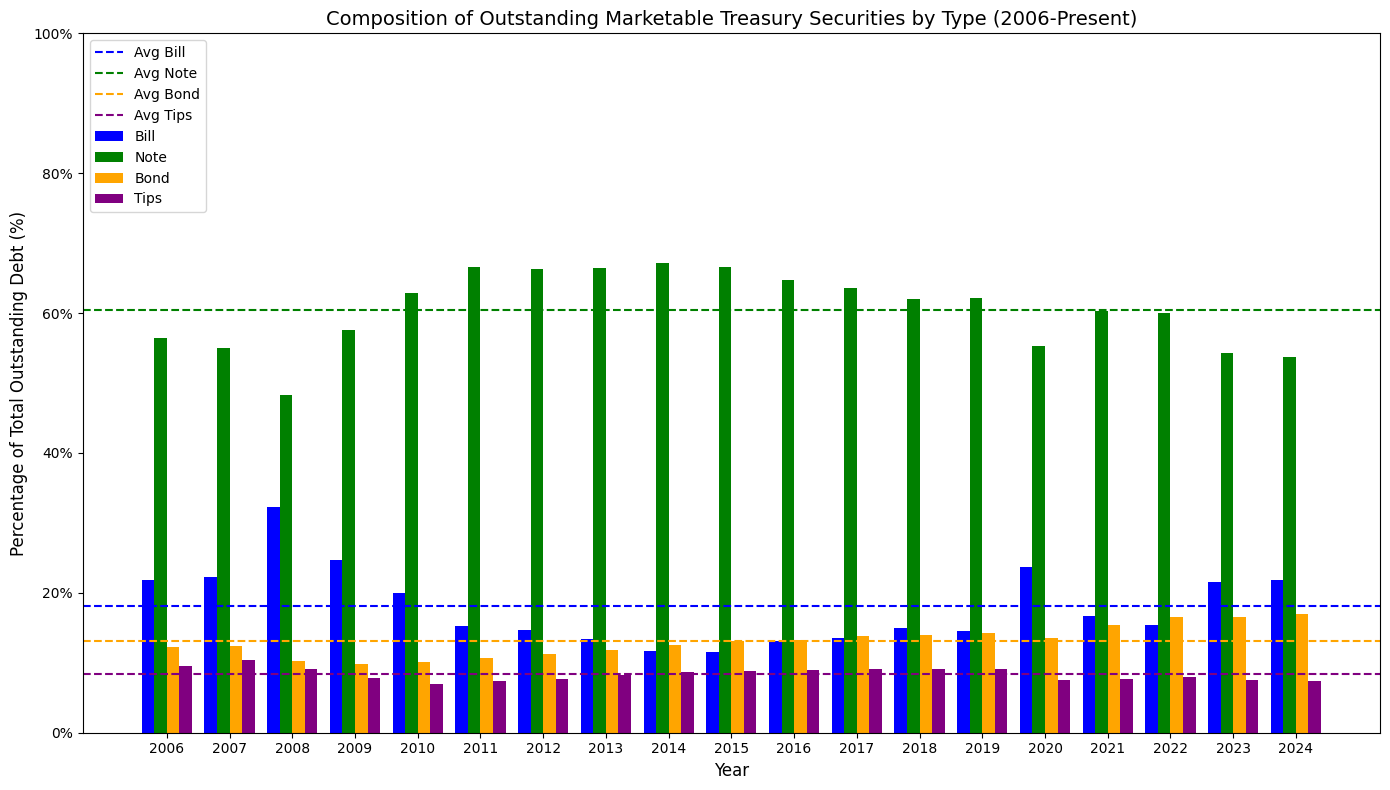

In [16]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime
from matplotlib.ticker import PercentFormatter

# -----------------------------
# Part 1: Retrieve the Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/debt/mspd/mspd_table_1"

# Using fields: record_date, security_class_desc, and total_mil_amt.
params = {
    "fields": "record_date,security_class_desc,total_mil_amt",
    "sort": "record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

# Convert record_date to datetime and total_mil_amt to numeric.
df["record_date"] = pd.to_datetime(df["record_date"])
df["total_mil_amt"] = pd.to_numeric(df["total_mil_amt"], errors="coerce")

# Print unique security_class_desc values.
unique_sec_types = set(df["security_class_desc"].unique())
print("Unique security_class_desc values in the dataset:")
print(unique_sec_types)

# -----------------------------
# Part 2: Categorize by Security Type
# -----------------------------
def categorize_security_desc(desc):
    desc = desc.lower()
    if "bill" in desc:
        return "Bill"
    elif "note" in desc:
        return "Note"
    elif "bond" in desc:
        return "Bond"
    elif "inflation" in desc:  # Assuming this identifies TIPS
        return "Tips"
    else:
        return "Other"

df["category"] = df["security_class_desc"].apply(categorize_security_desc)
print("Data after categorization (first 5 rows):")
print(df.head())

# -----------------------------
# Part 3: Get Year-End Outstanding Values
# -----------------------------
# Reset the index so that record_date is a column.
df_reset = df.reset_index(drop=True)
# Group by record_date and category, summing total_mil_amt for each day.
daily_pivot = df_reset.groupby(["record_date", "category"])["total_mil_amt"].sum().unstack(fill_value=0)
# daily_pivot now has one row per record_date with columns for each category.

# For each year, select the row with the maximum record_date (year-end snapshot).
daily_pivot["year"] = daily_pivot.index.year
annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])
# Set the index to be the year.
annual_data.index = annual_data.index.get_level_values(0)
# Convert outstanding amounts from millions to dollars.
annual_data = annual_data * 1e6

print("Annual Outstanding Debt by Type (Year-End):")
print(annual_data.head())

# Extract the values for each category.
years = sorted(annual_data.index)
bills = annual_data.get("Bill", pd.Series(0, index=years))
notes = annual_data.get("Note", pd.Series(0, index=years))
bonds = annual_data.get("Bond", pd.Series(0, index=years))
tips = annual_data.get("Tips", pd.Series(0, index=years))

# Create a DataFrame that holds the absolute outstanding values.
abs_data = pd.DataFrame({
    "Bill": bills,
    "Note": notes,
    "Bond": bonds,
    "Tips": tips
}, index=years)

# -----------------------------
# Part 4: Compute Percentage Shares
# -----------------------------
# For each year, compute the percentage that each category contributes to the total outstanding debt.
total_outstanding = abs_data.sum(axis=1)
percent_data = abs_data.div(total_outstanding, axis=0) * 100

print("Percentage Share of Outstanding Debt by Type (Year-End):")
print(percent_data.head())

# -----------------------------
# Part 5: Compute Average Percentage for Each Type
# -----------------------------
avg_bill = percent_data["Bill"].mean()
avg_note = percent_data["Note"].mean()
avg_bond = percent_data["Bond"].mean()
avg_tips = percent_data["Tips"].mean()

# -----------------------------
# Part 6: Plot the Percentage Shares as Grouped Bars with Average Lines
# -----------------------------
x = np.arange(len(years))
width = 0.20  # Bar width

fig, ax = plt.subplots(figsize=(14, 8))

# Position the bars for each category.
ax.bar(x - 1.5*width, percent_data["Bill"], width, color='blue', label='Bill')
ax.bar(x - 0.5*width, percent_data["Note"], width, color='green', label='Note')
ax.bar(x + 0.5*width, percent_data["Bond"], width, color='orange', label='Bond')
ax.bar(x + 1.5*width, percent_data["Tips"], width, color='purple', label='Tips')

# Plot average dashed lines.
ax.axhline(y=avg_bill, color='blue', linestyle='--', label='Avg Bill')
ax.axhline(y=avg_note, color='green', linestyle='--', label='Avg Note')
ax.axhline(y=avg_bond, color='orange', linestyle='--', label='Avg Bond')
ax.axhline(y=avg_tips, color='purple', linestyle='--', label='Avg Tips')

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Percentage of Total Outstanding Debt (%)", fontsize=12)
ax.set_title("Composition of Outstanding Marketable Treasury Securities by Type (2006-Present)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(PercentFormatter())

# Combine legend entries (avoid duplicate labels).
handles, labels = ax.get_legend_handles_labels()
# To remove duplicate labels, we can create a dict.
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc='upper left')

plt.tight_layout()
plt.show()

Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/debt/mspd/mspd_table_1
Response: <Response [200]>
Unique security_class_desc values in the dataset:
{'Treasury Inflation-Protected Securities', 'United States Savings Securities', 'Domestic Series', '_', 'Other', 'Floating Rate Notes', 'State and Local Government Series', 'Foreign Series', 'Government Account Series', 'Notes', 'Hope Bonds', 'Bonds', 'Federal Financing Bank', 'R.E.A. Series', 'Bills'}
Data after categorization (first 5 rows):
  record_date                      security_class_desc  total_mil_amt category
0  2006-01-31                                    Bills   9.562498e+05     Bill
1  2006-01-31                                    Notes   2.361102e+06     Note
2  2006-01-31                                    Bonds   5.166188e+05     Bond
3  2006-01-31  Treasury Inflation-Protected Securities   3.468606e+05     Tips
4  2006-01-31                   Federal Financing Bank   1.400000e+04    Other


/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_22163/3441965117.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])
/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_22163/3441965117.py:102: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  deficit_annual = deficit_series.resample("A").mean()


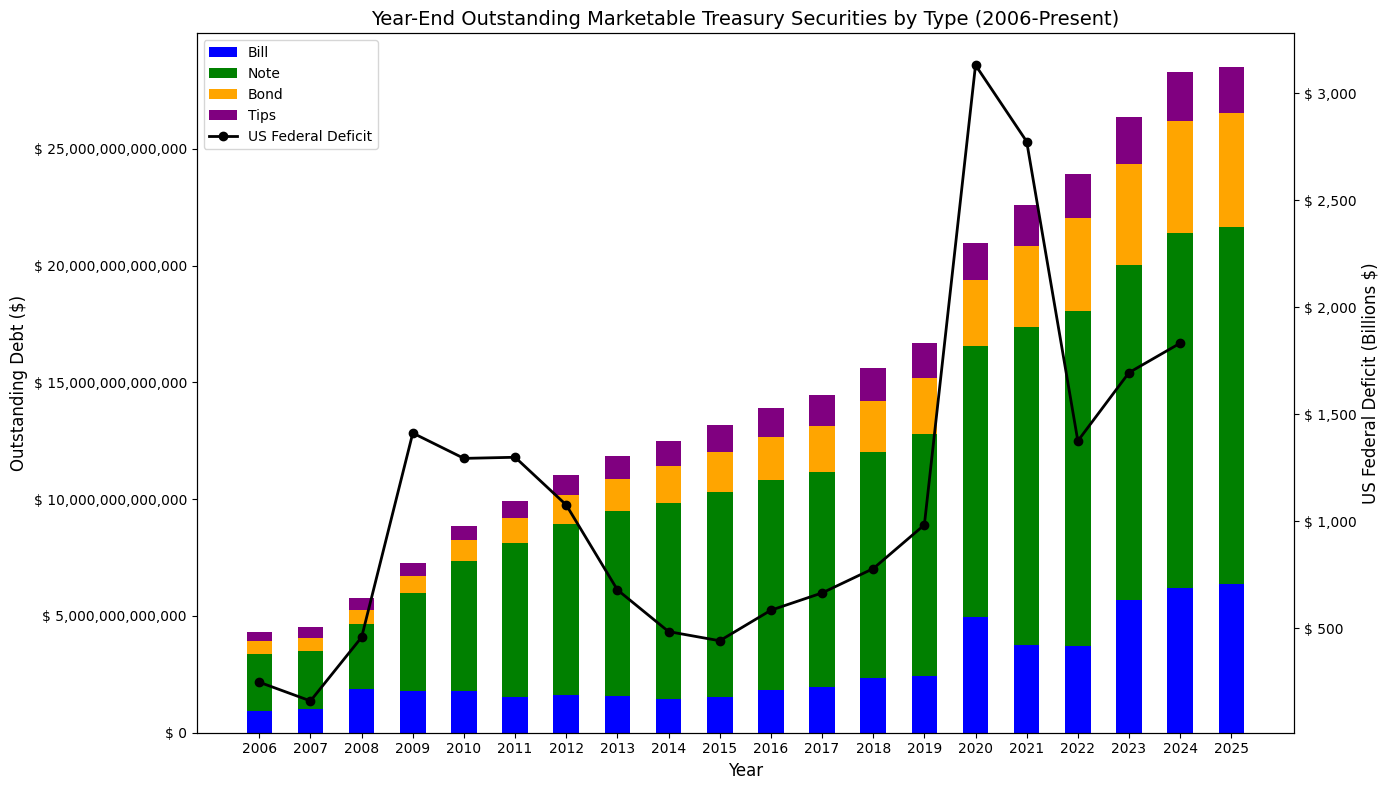

In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter

# -----------------------------
# Part 1: Retrieve the Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/debt/mspd/mspd_table_1"

params = {
    "fields": "record_date,security_class_desc,total_mil_amt",
    "sort": "record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

# Convert record_date to datetime and total_mil_amt to numeric.
df["record_date"] = pd.to_datetime(df["record_date"])
df["total_mil_amt"] = pd.to_numeric(df["total_mil_amt"], errors="coerce")

# Print unique security_class_desc values.
unique_sec_types = set(df["security_class_desc"].unique())
print("Unique security_class_desc values in the dataset:")
print(unique_sec_types)

# -----------------------------
# Part 2: Categorize by Security Type
# -----------------------------
def categorize_security_desc(desc):
    desc = desc.lower()
    if "bill" in desc:
        return "Bill"
    elif "note" in desc:
        return "Note"
    elif "bond" in desc:
        return "Bond"
    elif "inflation" in desc:
        return "Tips"
    else:
        return "Other"

df["category"] = df["security_class_desc"].apply(categorize_security_desc)
print("Data after categorization (first 5 rows):")
print(df.head())

# -----------------------------
# Part 3: Get Year-End Outstanding Values
# -----------------------------
df_reset = df.reset_index(drop=True)
daily_pivot = df_reset.groupby(["record_date", "category"])["total_mil_amt"].sum().unstack(fill_value=0)
daily_pivot["year"] = daily_pivot.index.year
annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])

# Replace the index with just the 'year' level.
annual_data.index = annual_data.index.get_level_values(0)

# Convert from millions to full dollar amounts.
annual_data = annual_data * 1e6

print("Annual Outstanding Debt by Type (Year-End):")
print(annual_data.head())

# Extract the values for each category.
years = sorted(annual_data.index)
bills = annual_data.get("Bill", pd.Series(0, index=years))
notes = annual_data.get("Note", pd.Series(0, index=years))
bonds = annual_data.get("Bond", pd.Series(0, index=years))
others = annual_data.get("Tips", pd.Series(0, index=years))

# -----------------------------
# Part 4: Retrieve US Federal Deficit Data from FRED
# -----------------------------
fred = Fred(api_key="b1b93f854d911b3cdc94df6dd9ec0365")
deficit_series = fred.get_series("FYFSD", observation_start="2006-01-01")
deficit_annual = deficit_series.resample("A").mean()

# Invert the deficit and convert to billions.
deficit_annual = (-deficit_annual) / 1000
deficit_annual.index = deficit_annual.index.year
deficit_annual = deficit_annual.reindex(years, fill_value=np.nan)

# -----------------------------
# Part 5: Plot Stacked Bars and Deficit
# -----------------------------
x = np.arange(len(years))
width = 0.5  # You can adjust as needed.

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot a single stacked bar for each year
bar_bills = ax1.bar(x, bills, width, color='blue', label='Bill')
bar_notes = ax1.bar(x, notes, width, bottom=bills, color='green', label='Note')
bar_bonds = ax1.bar(x, bonds, width, bottom=bills + notes, color='orange', label='Bond')
bar_others = ax1.bar(x, others, width, bottom=bills + notes + bonds, color='purple', label='Tips')

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Outstanding Debt ($)", fontsize=12)
ax1.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))
ax1.set_title("Year-End Outstanding Marketable Treasury Securities by Type (2006-Present)", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Secondary y-axis for the US Federal Deficit
ax2 = ax1.twinx()
ax2.plot(x, deficit_annual.values, color='black', marker='o', linewidth=2, label="US Federal Deficit")
ax2.set_ylabel("US Federal Deficit (Billions $)", fontsize=12)
ax2.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))

# Combine legends from both axes
bars, labels = ax1.get_legend_handles_labels()
line, line_label = ax2.get_legend_handles_labels()
ax1.legend(bars + line, labels + line_label, loc='upper left')

plt.tight_layout()
plt.show()

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO

# ------------------------------------------------------------------
# Define functions to fetch and process the Excel files
# ------------------------------------------------------------------

def fetch_excel_data(api_url):
    """
    Fetch an Excel file from a given URL and return a DataFrame.
    Assumes the first column contains dates.
    """
    response = requests.get(api_url)
    if response.status_code == 200:
        # Read Excel from the downloaded bytes; 
        # adjust header/index_col as needed based on file structure.
        return pd.read_excel(BytesIO(response.content), index_col=0, parse_dates=True)
    else:
        print(f"Failed to fetch data: {response.status_code} for {api_url}")
        return None

def process_file(api_url):
    """
    Process one Excel file:
      - Download the file.
      - Sum across all numeric columns (assumed to be different subcategories)
        to get a daily total.
      - Resample to monthly frequency taking the last available day.
    Returns a DataFrame with a 'Total' column and a datetime index.
    """
    df = fetch_excel_data(api_url)
    if df is None:
        return None
    # Sum all numeric columns to get a daily total.
    df['Total'] = df.select_dtypes(include='number').sum(axis=1)
    # Resample to monthly frequency taking the last available observation.
    df_monthly = df.resample('M').last()[['Total']]
    return df_monthly

def aggregate_period(urls):
    """
    Given a list of API URLs for a reporting period,
    process each file and aggregate (sum) their totals by date.
    Returns a DataFrame with a datetime index and a combined 'Total' column.
    """
    monthly_totals = []  # list of DataFrames for each file
    for url in urls:
        df = process_file(url)
        if df is not None:
            monthly_totals.append(df)
    if not monthly_totals:
        return None
    # Combine (concatenate) the DataFrames along columns so that they align by date
    combined = pd.concat(monthly_totals, axis=1)
    # Sum across the columns to get one total per date.
    combined['Total'] = combined.sum(axis=1)
    return combined[['Total']]

# ------------------------------------------------------------------
# Define the API URLs for each period.
# (The URLs below are taken from your list.)
# ------------------------------------------------------------------

# Period 1: Jan 2015 to Dec 2021
urls_2015_2021 = [
    "https://markets.newyorkfed.org/api/pd/get/SBN2015/timeseries/PDSIRRA-UTSET_PDSIRRA-UTSETTAL30_PDSIRRA-UTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2015/timeseries/PDSIOSB-UTSET_PDSIOSB-UTSETTA30_PDSIOSB-UTSETTAG30.xlsx"
]

# Period 2: Jan 2022 to Jun 2024
urls_2022_2024 = [
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIRRA-UBSUTSET_PDSIRRA-UBSUTSETTAL30_PDSIRRA-UBSUTSETTAG30_PDSIRRA-UBGUTSET_PDSIRRA-UBGUTSETTAL30_PDSIRRA-UBGUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIRRA-CBSUTSET_PDSIRRA-CBSUTSETTAL30_PDSIRRA-CBSUTSETTAG30_PDSIRRA-CBGUTSET_PDSIRRA-CBGUTSETTAL30_PDSIRRA-CBGUTSETTAG30_PDSIRRA-CBSPUTSET_PDSIRRA-CBSPUTSETTAL30_PDSIRRA-CBSPUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIRRA-GCFUTSET_PDSIRRA-GCFUTSETTAL30_PDSIRRA-GCFUTSETTAG30_PDSIRRA-TRIUTSET_PDSIRRA-TRIUTSETTAL30_PDSIRRA-TRIUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIOSB-UTSET_PDSIOSB-UTSETTA30_PDSIOSB-UTSETTAG30.xlsx"
]

# Period 3: Jun 2024 to Present
urls_2024_present = [
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSORA-UBSE_PDSORA-UBSETAL30_PDSORA-UBSETAG30_PDSORA-UBGE_PDSORA-UBGETAL30_PDSORA-UBGETAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSIRRA-CBSUTSET_PDSIRRA-CBSUTSETTAL30_PDSIRRA-CBSUTSETTAG30_PDSIRRA-CBGUTSET_PDSIRRA-CBGUTSETTAL30_PDSIRRA-CBGUTSETTAG30_PDSIRRA-CBSPUTSET_PDSIRRA-CBSPUTSETTAL30_PDSIRRA-CBSPUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSIRRA-GCFUTSET_PDSIRRA-GCFUTSETTAL30_PDSIRRA-GCFUTSETTAG30_PDSIRRA-TRIGUTSET_PDSIRRA-TRIGUTSETTAL30_PDSIRRA-TRIGUTSETTAG30_PDSIRRA-TRISPUTSET_PDSIRRA-TRISPUTSETTAL30_PDSIRRA-TRISPUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSIOSB-UTSET_PDSIOSB-UTSETTA30_PDSIOSB-UTSETTAG30.xlsx"
]

# ------------------------------------------------------------------
# Process each period and aggregate the data.
# ------------------------------------------------------------------

df_2015_2021 = aggregate_period(urls_2015_2021)
df_2022_2024 = aggregate_period(urls_2022_2024)
df_2024_present = aggregate_period(urls_2024_present)

# Combine all periods into a single DataFrame and sort by date.
df_total = pd.concat([df_2015_2021, df_2022_2024, df_2024_present]).sort_index()

# ------------------------------------------------------------------
# Plot the aggregated reverse repo volume (last day of month)
# ------------------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(df_total.index, df_total['Total'], marker="o", label="Total Reverse Repo Volume")
plt.title("Aggregated Reverse Repo Volume (Last Day of Month)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volume", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [7]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1) GET THE DATA FROM FISCALDATA (TIC) ENDPOINT
# -------------------------------------------------

# Base endpoint for the "Major Foreign Holders" dataset
BASE_URL = (
    "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
    "/v2/accounting/od/mfh_statedata"
)

# We’ll collect rows in a loop until no more pages remain.
all_records = []
page_number = 1
page_size = 5000  # can adjust up to 10,000 per page if desired

while True:
    params = {
        "format": "json",
        "page[number]": page_number,
        "page[size]": page_size,
        "sort": "-reporting_date"  # newest first
    }
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    
    if "data" not in data or len(data["data"]) == 0:
        break  # no more data
    
    all_records.extend(data["data"])
    
    # check if there are more pages to fetch
    meta = data.get("meta", {})
    if "paging" in meta and "pages" in meta["paging"]:
        total_pages = meta["paging"]["pages"]
        if page_number >= total_pages:
            break
        else:
            page_number += 1
    else:
        # if paging info isn't structured as expected, just break
        break

# Convert to a DataFrame
df = pd.DataFrame(all_records)

# -------------------------------------------------
# 2) CLEAN AND PREP THE DATA
# -------------------------------------------------

# Convert reporting_date to a proper datetime
df["reporting_date"] = pd.to_datetime(df["reporting_date"])

# The column "tot_securities" holds the total value (in millions of USD).
# Make sure it's numeric.
df["tot_securities"] = pd.to_numeric(df["tot_securities"], errors="coerce")

# We only need certain columns:
#   reporting_date (monthly)
#   country_name
#   tot_securities  (in millions)
df = df[["reporting_date", "country_name", "tot_securities"]]

# Some rows might have NaN or 0 "tot_securities"; drop them to avoid noise:
df.dropna(subset=["tot_securities"], inplace=True)

# -------------------------------------------------
# 3) AGGREGATE TO GET TOTAL FOREIGN + TOP 5 COUNTRIES
# -------------------------------------------------

# (A) TOTAL FOREIGN OWNERSHIP across time
# Just sum over all countries for each reporting_date.
total_foreign_df = (
    df.groupby("reporting_date")["tot_securities"]
      .sum()
      .rename("total_foreign_holdings")
      .reset_index()
)

# (B) Identify top 5 countries by their peak (or latest) holdings
# Here we’ll define "top" by the maximum holdings each country ever had
country_peaks = (
    df.groupby("country_name")["tot_securities"]
      .max()
      .sort_values(ascending=False)
)
top_5_countries = list(country_peaks.head(5).index)

# Filter the main df to just those top 5
df_top_5 = df[df["country_name"].isin(top_5_countries)]

# Pivot to get each country as a column
df_top_5_pivot = (
    df_top_5.pivot_table(
        index="reporting_date",
        columns="country_name",
        values="tot_securities",
        aggfunc="sum"  # though each (date, country) should appear once
    )
)

# -------------------------------------------------
# 4) PLOT THE RESULTS
# -------------------------------------------------
plt.figure(figsize=(10, 6))

# Plot total foreign line
plt.plot(
    total_foreign_df["reporting_date"],
    total_foreign_df["total_foreign_holdings"] / 1e3,  # convert millions->billions
    label="Total Foreign Holdings (All Countries)",
    color="black",
    linewidth=2
)

# Plot each top-5 country with a dashed line
line_styles = ["--", "-.", ":", (0, (3, 1, 1, 1)), (0, (5, 10))]  # variety of dash styles
for i, country in enumerate(df_top_5_pivot.columns):
    plt.plot(
        df_top_5_pivot.index,
        df_top_5_pivot[country] / 1e3,  # from millions to billions
        label=country,
        linestyle=line_styles[i % len(line_styles)]
    )

plt.title("Foreign Holdings of U.S. Treasuries Over Time")
plt.xlabel("Date")
plt.ylabel("Treasury Holdings (USD billions)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'reporting_date'

           Country 2024-11 2024-10 2024-09 2024-08 2024-07 2024-06 2024-05  \
0            Japan  1098.8  1101.9  1123.0  1128.9  1115.4  1117.4  1128.3   
1  China, Mainland   768.6   760.1   772.0   774.6   776.5   780.2   768.3   
2   United Kingdom   765.6   743.3   764.4   743.7   728.2   741.4   723.4   
3       Luxembourg   424.5   420.1   417.9   402.1   400.0   384.3   385.4   
4   Cayman Islands   397.0   409.7   419.8   419.2   377.8   319.2   336.5   
5           Canada   374.4   365.7   369.8   365.0   377.3   373.6   357.4   
6          Belgium   361.3   349.6   366.6   325.0   315.9   318.0   313.0   
7          Ireland   338.1   332.0   327.9   322.4   313.1   308.4   317.9   
8           France   332.5   330.1   328.9   312.5   291.1   307.4   283.1   
9      Switzerland   300.6   300.4   304.2   297.2   286.1   287.6   291.0   

  2024-04 2024-03 2024-02 2024-01 2023-12 2023-11  
0  1150.3  1187.8  1167.9  1151.5  1136.7  1127.5  
1   770.7   767.4   775.0   797.7   8

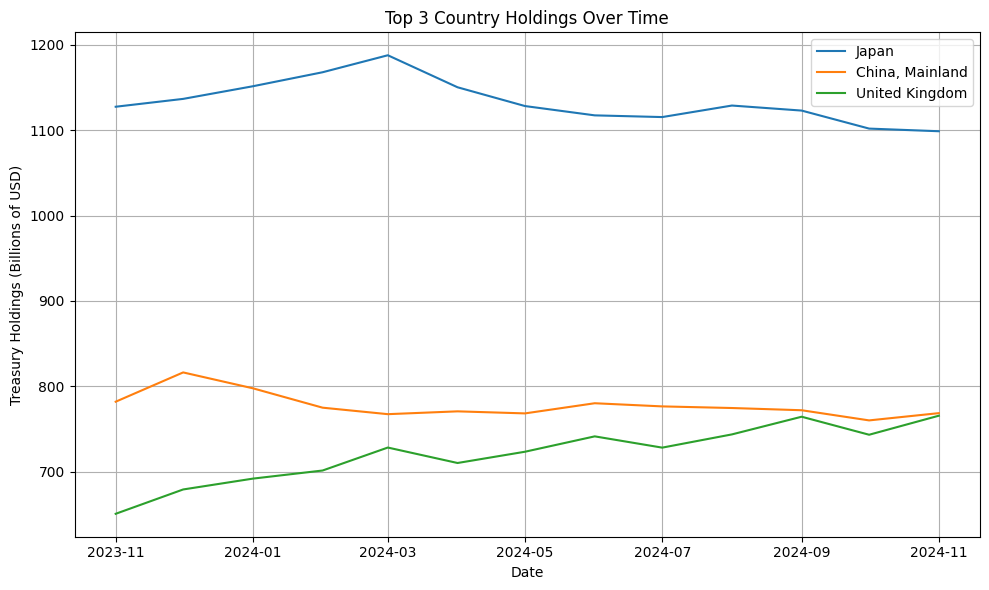

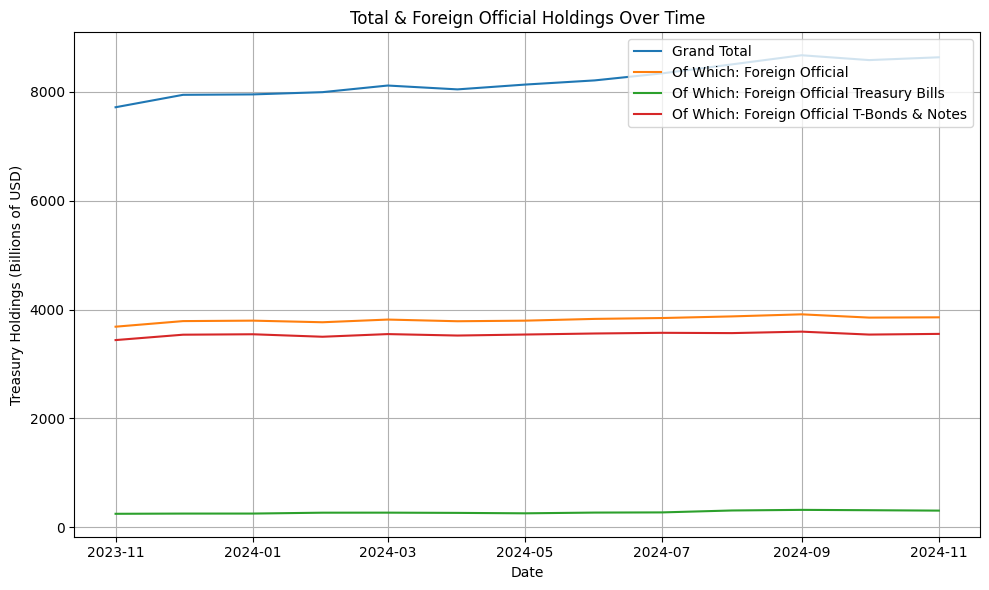

In [13]:
table_text = """
Country	2024-11	2024-10	2024-09	2024-08	2024-07	2024-06	2024-05	2024-04	2024-03	2024-02	2024-01	2023-12	2023-11
Japan	1098.8	1101.9	1123.0	1128.9	1115.4	1117.4	1128.3	1150.3	1187.8	1167.9	1151.5	1136.7	1127.5
China, Mainland	768.6	760.1	772.0	774.6	776.5	780.2	768.3	770.7	767.4	775.0	797.7	816.3	782.0
United Kingdom	765.6	743.3	764.4	743.7	728.2	741.4	723.4	710.2	728.3	701.4	691.9	679.2	650.7
Luxembourg	424.5	420.1	417.9	402.1	400.0	384.3	385.4	385.9	401.0	380.5	376.6	370.7	371.2
Cayman Islands	397.0	409.7	419.8	419.2	377.8	319.2	336.5	319.4	303.5	302.7	318.7	305.5	319.2
Canada	374.4	365.7	369.8	365.0	377.3	373.6	357.4	342.7	369.4	364.2	350.3	347.3	321.1
Belgium	361.3	349.6	366.6	325.0	315.9	318.0	313.0	312.4	317.1	320.0	293.1	314.4	296.5
Ireland	338.1	332.0	327.9	322.4	313.1	308.4	317.9	307.7	317.8	317.0	319.0	331.6	314.3
France	332.5	330.1	328.9	312.5	291.1	307.4	283.1	276.6	271.9	271.5	256.4	236.7	245.7
Switzerland	300.6	300.4	304.2	297.2	286.1	287.6	291.0	291.8	283.8	277.8	283.4	288.2	276.4
Taiwan	286.9	285.0	288.2	284.4	275.0	265.9	263.3	257.3	259.0	255.6	255.9	252.5	238.0
Singapore	257.7	250.5	248.3	239.0	234.2	219.6	213.5	207.5	208.0	205.4	204.7	199.5	196.2
Hong Kong	255.7	248.3	233.1	236.0	230.6	220.8	217.6	221.0	202.2	212.6	228.5	234.2	211.1
India	234.0	241.4	247.2	245.9	238.8	241.9	237.8	233.5	240.6	234.7	236.1	233.7	224.9
Brazil	229.0	228.8	234.6	233.3	229.1	227.0	223.2	223.6	227.1	225.6	226.8	230.3	224.9
Norway	159.0	161.8	170.1	164.4	158.8	153.4	142.8	138.3	148.7	138.6	144.9	126.1	113.6
Saudi Arabia	135.6	139.2	143.9	142.8	142.7	140.2	136.3	135.4	135.9	131.1	133.5	132.0	128.1
Korea, South	127.8	127.4	127.0	122.9	122.7	116.7	120.2	119.9	115.9	119.2	118.6	119.0	116.0
Mexico	100.8	99.0	95.8	95.7	95.4	95.8	99.3	93.6	88.9	80.3	75.9	77.9	75.6
Germany	97.7	100.1	101.1	96.1	101.6	87.6	87.9	87.1	90.2	90.8	90.2	87.3	86.1
All Other	1589.0	1588.7	1588.0	1553.0	1528.4	1503.4	1486.8	1459.7	1450.8	1422.0	1398.8	1425.8	1397.3
Grand Total	8634.6	8583.0	8671.8	8504.1	8338.9	8209.8	8133.0	8044.8	8115.5	7993.8	7952.5	7944.8	7716.5
Of Which: Foreign Official	3856.3	3851.1	3911.2	3873.2	3843.3	3827.5	3794.9	3784.2	3815.0	3765.7	3795.3	3786.9	3684.1
Of Which: Foreign Official Treasury Bills	304.4	311.8	318.1	306.9	271.6	268.3	254.8	262.7	267.0	266.3	250.3	250.0	246.0
Of Which: Foreign Official T-Bonds & Notes	3551.9	3539.3	3593.2	3566.3	3571.7	3559.2	3540.1	3521.5	3548.1	3499.4	3545.0	3537.0	3438.1"""


import pandas as pd

lines = table_text.strip().split("\n")

# Find the header line index
header_line_idx = None
for i, line in enumerate(lines):
    if line.startswith("Country\t"):
        header_line_idx = i
        break

if header_line_idx is None:
    raise ValueError("Could not find the header line starting with 'Country'.")

# Extract the header row and split into columns
header_line = lines[header_line_idx]
headers = header_line.split("\t")  # using tab separation

# We'll store data rows in a list of lists
data_rows = []
for line in lines[header_line_idx + 1:]:
    # stop if we reach blank lines or lines that look like notes
    if not line.strip():
        break
    
    # "Of Which:" lines also might appear; handle them if you want them
    if line.startswith("Of Which:"):
        # We'll keep them in the dataset or skip, depending on preference
        pass
    
    # Attempt to parse as tab-separated columns
    cols = line.split("\t")
    
    # Basic check: must match header length
    # or at least we know we have 1 (Country) + many data points
    if len(cols) < 2:
        # Possibly a note line or something else
        continue
    
    data_rows.append(cols)

# Create DataFrame
df = pd.DataFrame(data_rows, columns=headers)

# Let's inspect
print(df.head(10))

df_melted = df.melt(
    id_vars=["Country"], 
    var_name="YearMonth", 
    value_name="Holdings"
)

df_melted["Holdings"] = pd.to_numeric(df_melted["Holdings"], errors="coerce")
df_melted["YearMonth"] = pd.to_datetime(df_melted["YearMonth"], format="%Y-%m")

# ----------------------
# 2) Plot #1: Top 3 Countries
# ----------------------
top_3_countries = ["Japan", "China, Mainland", "United Kingdom"]
df_top_3 = df_melted[df_melted["Country"].isin(top_3_countries)].copy()
df_top_3.sort_values(["Country", "YearMonth"], inplace=True)

plt.figure(figsize=(10, 6))

for country in top_3_countries:
    subset = df_top_3[df_top_3["Country"] == country]
    plt.plot(
        subset["YearMonth"], 
        subset["Holdings"], 
        label=country
    )

plt.title("Top 3 Country Holdings Over Time")
plt.xlabel("Date")
plt.ylabel("Treasury Holdings (Billions of USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------
# 3) Plot #2: Grand Total & Foreign Official Lines
# ----------------------
official_labels = [
    "Grand Total",
    "Of Which: Foreign Official",
    "Of Which: Foreign Official Treasury Bills",
    "Of Which: Foreign Official T-Bonds & Notes"
]
df_official = df_melted[df_melted["Country"].isin(official_labels)].copy()
df_official.sort_values(["Country", "YearMonth"], inplace=True)

plt.figure(figsize=(10, 6))

for label in official_labels:
    subset = df_official[df_official["Country"] == label]
    plt.plot(
        subset["YearMonth"], 
        subset["Holdings"], 
        label=label
    )

plt.title("Total & Foreign Official Holdings Over Time")
plt.xlabel("Date")
plt.ylabel("Treasury Holdings (Billions of USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()